__Hassan Mojeed__<br>
[Linkedin Profile](https://www.linkedin.com/in/hassanmojeed/)<br>
_mojeed.o.hassan@gmail.com_

## Numbers Speak: Analyzing The Strategies And Engagement Patterns of Data Analyst YouTubers.

## Phase 1 - Thought Process

### Introduction:

In this exciting project, I'm delving deep into the world of some of the top **YouTube data analyst content creators** in my opinion, that I follow and learn from. My mission is to uncover their winning strategies for captivating the right audience and understand how these strategies shape their results.

### Dataset:
I'll be tapping into the YouTube API to gather the necessary data for my analysis. This adventure involves obtaining channel IDs and fetching video IDs from these channels. For each video, I'll be focusing on these key attributes:

- Number of views
- Number of Likes
- Number of Comments
- Category ID
- Description
- Video duration
- Publishing Date

### Data Processing:
Before I dive into the analysis, I've meticulously transformed each data field into the appropriate format:

- Views are now integers
- Likes are now integers
- Comments are now integers
- Video duration is in float format
- Publishing date is in datetime format*

### Engagement and Views:
It's not just data; I'm measuring user engagement and scrutinizing the comments-to-likes ratio. Additionally, I'm keeping an eye on the average monthly views to understand the monthly viewership each content creator garners.

### Analysis Video  Counts and Duration:
My journey takes me into the realm of video counts and duration.

### Publishing Strategy:
Here, I aim to decipher how content creators optimize their content.

### Analysis of Tags, Titles and Words ranked by views:
In the quest for insights, I'm unraveling the mysteries behind tags and titles. By identifying the most frequently used tags, I will gain valuable insights into the most used words in video titles that got content creators more viewerships.

### Data Analyst Content creators in view:

- Alex Freberg (Alexthedataanalyst)
- Leila Gharani (Xelplus)
- Chandoo
- Jamie keet (Teacher's Tech)


## Phase 2 - Data Collection

I will be using the YOUTUBE API to get access to the data I need.

### Importing necessary packages

In [1]:
#Importing Custom Modules
from YOUTUBE_API_KEY import api_key #Importing the API key


#Importing all the necessary packages
import requests
from tqdm import tqdm  #this is just to display a progress bar
import pandas as pd
import numpy as np
import json
import re


#importing modules for Text Data Analysis
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#importing modules for visulizations
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### Defining some useful dictionaries

In [2]:

#For convenience, I will create a dictionary to assign key to each channel name.
channel_names = {0 : 'Leila Gharani'
                 ,1 : 'Chandoo'
                 ,2 : 'Alex The Analyst'
                 ,3 : '''Teacher's Tech'''
                }


#Mapping channel name with its ID

channelnames_id = {'Leila Gharani' : 'UCJtUOos_MwJa_Ewii-R3cJA'
                    ,'Chandoo' : 'UC8uU_wruBMHeeRma49dtZKA'
                    ,'Alex The Analyst' : 'UC7cs8q-gJRlGwj4A8OmCmXg'
                   ,'''Teacher's Tech''' : 'UCO66zvpQorlNfs_7hFCfmaw'
                   }


### Creating some functions that will be needed later.

In [3]:
def get_channel_video_ids(channel_id,api_key):
    
    '''
    This function retrieves all video ids from a channel.
    
    channel_id : indicates the Id of the Youtube channel.
    
    api_key : indicates the api access to Youtube.
    
    
    '''
    
    #the root Endpoint of YOUTUBEAPI
    base_url = 'https://www.googleapis.com/youtube/v3'
    
    url = f'{base_url}/channels'
    
    params = {
        'id' : channel_id,
        'key' : api_key,
        'part' : 'contentDetails'
    }
    
    res = requests.get(url, params=params).json()
    
    #for every video uploaded on YOUTUBE a special playlist is automatically created,
    #this playlist is hidden to viewers, we need to get the id of this playlist in order to get the video ids
    
    playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    
    videos = []
    page_token = None
    
    while True:
        
        url = f'{base_url}/playlistItems'

        params = {
            'playlistId': playlist_id,
            'part': 'snippet',
            'maxResults': 50,
            'key': api_key
        }
    # pageToken is a token or string that you use to request specific pages of data when the result set 
    # is too large to be returned in a single response.
        if page_token:
            params["pageToken"] = page_token

        res = requests.get(url, params=params).json()
        videos += res['items']
        page_token = res.get('nextPageToken')
        
        if not page_token:
            break

    return [video['snippet']['resourceId']['videoId'] for video in videos]


def get_video_stats(video_id, api_key):
        
    '''
    This returns the statistics for a list of video ids.
    
    video_id - the id of a YouTube video
    api_key - the API key to access YouTube API
    '''
    url = "https://youtube.googleapis.com/youtube/v3/videos"
    params = {
              "key":api_key, 
              "part": "snippet, contentDetails, statistics", 
              "id":video_id
             }
    response = requests.request("GET", url, params=params).json()
    
    return response


def get_stats_for_channels(channelnames_id, api_key):
    
    '''
    This returns a dictionary of the form:  {channel name 0: {
                                          video id 0: 
                                            video statistics, 
                                          video id 1:
                                            video statistics,
                                            ...
                                            },
                                         channel name 1: {...}}
    
    author_channelId - dict where keys are channel titles and values are channel IDs
    '''
    name_videoId = {}
    video_stats_dict = {}
    for name, channel_id in tqdm(channelnames_id.items()):
        name_videoId[name] = get_channel_video_ids(channel_id, api_key)
        n_videos =  len(name_videoId[name])
        print(f'Number of videos of {name} is {n_videos}')

        for videoId in name_videoId[name]:
            video_stats = get_video_stats(videoId, api_key)
            video_stats_dict[videoId] = video_stats
            
    return video_stats_dict 


def save_dict_to_json(d, filename):
    with open(filename, 'w') as f:
        json.dump(d, f)
        

def print_charts(chart_list, height):
    '''
    This displays multiple charts one by one.
    
    chart_list - list of plotly charts
    '''
    fig = make_subplots(
                        rows=len(chart_list), 
                        cols=1, 
                        subplot_titles = [chart_list[i].layout.title.text for i in range(len(chart_list))]
                       )
                        
    # Add traces from fig1 to the subplot        
    for i, chart in enumerate(chart_list):
        for trace in chart['data'] :
            fig.add_trace(trace, row = i + 1, col = 1 )


    # Update layout to match the individual figures
    fig.update_layout(height=height) 
    fig.show()
    
    
#the funtion converts  duration of videos to minutes
def duration_to_minutes(duration_str):
    # Regular expression to extract hours, minutes, and seconds
    pattern = r'PT((?P<hours>\d+)H)?((?P<minutes>\d+)M)?((?P<seconds>\d+)S)?'
    
    match = re.match(pattern, duration_str)
    if not match:
        return None
    
    # Extract hours, minutes, and seconds
    hours = int(match.group('hours') or 0)
    minutes = int(match.group('minutes') or 0)
    seconds = int(match.group('seconds') or 0)
    
    # Convert everything to minutes
    total_minutes = hours * 60 + minutes + seconds / 60.0
    return total_minutes


def get_and_to_dataframe(channelnames_id, api_key):
    
    '''
    The function accepts a channel id and api key and returns the output in pandas dataframe.
    this function can used directly to get the dataframe instead of a raw json file.
    
    '''
    result_dict = {}
    video_stats_dict = get_stats_for_channels(channelnames_id, api_key)
    
    #modifying the dictionary in order to keep the items needed for analysis
    indicators = {
        'statistics': ['viewCount', 'likeCount', 'commentCount'],
        'snippet': ['channelTitle', 'publishedAt', 'tags', 'categoryId', 'title', 'description'],
        'contentDetails': ['duration']
    }

    for i in video_stats_dict.keys():
        video_info_dict = video_stats_dict[i]['items'][0]
        
        video_id = video_info_dict['id']
        
        video_data = {}

        for parent_key, attributes in indicators.items():
            for attribute in attributes:
                try:
                    if parent_key in video_info_dict:
                        video_data[attribute] = video_info_dict[parent_key].get(attribute, None)
                except Exception as e:
                    video_data[attribute] = None


        result_dict[video_id] = video_data
        data = pd.DataFrame(result_dict).T
        data['tags'] = data['tags'].apply(lambda x: [] if x is None else x)
    return data


In [4]:
data = get_and_to_dataframe(channelnames_id, api_key)
data.head(3)

  0%|          | 0/4 [00:00<?, ?it/s]

Number of videos of Leila Gharani is 568


 25%|██▌       | 1/4 [17:09<51:28, 1029.38s/it]

Number of videos of Chandoo is 454


 50%|█████     | 2/4 [26:39<25:18, 759.44s/it] 

Number of videos of Alex The Analyst is 262


 75%|███████▌  | 3/4 [32:16<09:26, 566.54s/it]

Number of videos of Teacher's Tech is 345


100%|██████████| 4/4 [41:33<00:00, 623.38s/it]


viewCount likeCount commentCount   channelTitle  \
DNl9DzNwjv8    214848      8845          540  Leila Gharani   
rpJss_pIn24     20804       869           32  Leila Gharani   
hBJgHQuhvmA     19364      1068            9  Leila Gharani   

                      publishedAt  \
DNl9DzNwjv8  2023-11-16T10:00:08Z   
rpJss_pIn24  2023-11-12T12:00:43Z   
hBJgHQuhvmA  2023-11-05T12:00:37Z   

                                                          tags categoryId  \
DNl9DzNwjv8  [XelplusVis, Leila Gharani, Advanced Excel tri...         27   
rpJss_pIn24  [XelplusVis, Leila Gharani, XelPlus, Microsoft...         27   
hBJgHQuhvmA  [XelplusVis, Leila Gharani, Advanced Excel tri...         27   

                                                         title  \
DNl9DzNwjv8  Excel's NEW Checkboxes Are Incredibly Cool! He...   
rpJss_pIn24  Keep It Private 🤫 Instant Windows Shortcuts fo...   
hBJgHQuhvmA  How to Calculate Change / Variance in Pivot Ta...   

                                                   description  duration  
DNl9DzNwjv8  Join 400,000+ professionals in our courses: 👉 ...  PT14M24S  
rpJss_pIn24  Join 400,000+ professionals in our courses: ht...     PT38S  
hBJgHQuhvmA  Join 400,000+ professionals in our courses: ht...     PT57S


## Phase 3 - Data Processing

In the is section, I will need to convert some fields to the right format

In [5]:
data['publishedAt'] = pd.to_datetime(data['publishedAt'])
data['viewCount'] = data['viewCount'].fillna(0).apply(lambda x: int(x)) 
data['likeCount'] = data['likeCount'].fillna(0).apply(lambda x: int(x))
data['commentCount'] = data['commentCount'].fillna(0).apply(lambda x: int(x))
data['duration'] = data['duration'].apply(lambda t: duration_to_minutes(t))

Also, to create fairness in comparison, I will need to cut off the month of November in 2023 as this project was done half way into the month.

In [6]:
data_f = data[data['publishedAt'] < '2023-11-01']

In [7]:
data_f.shape

(1612, 10)

In [8]:
#Creating a color dictionary to assign color to each channel. This is for consistency.

color_dic = {'Leila Gharani' : '#be0aff'
             ,'Chandoo' : '#0496ff'
             ,'Alex The Analyst' : '#0c0f0a'
             ,'''Teacher's Tech''' : '#ffa737'
            }


## Phase 4 - Analysis

Here I will be conducting a deep dive analysis into the attributes mentioned earlier

### A. Engagements and Views

- How are the channels performing with regards to the number of views they garner per contents and
- what are the engagement levels like. What is the ratio of comments vs views

#### A quick peek into what the views per channel look like.

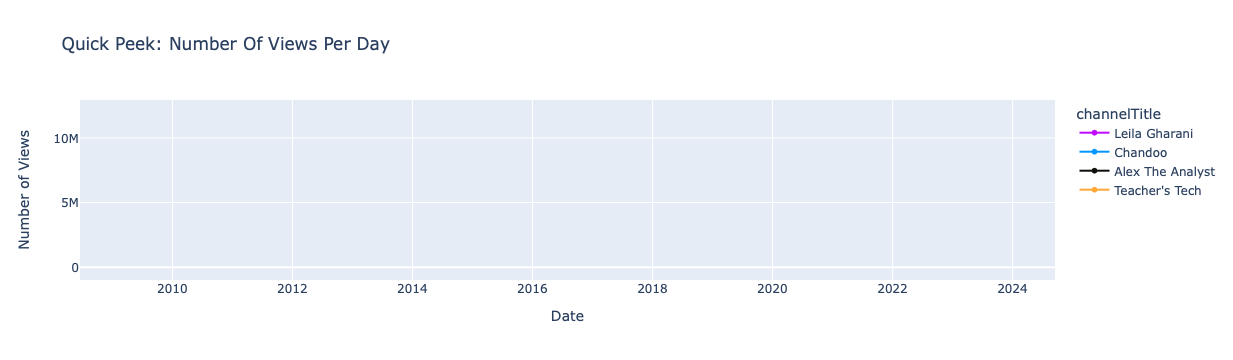

In [9]:
fig = px.line(data_f, x='publishedAt', y='viewCount', color='channelTitle', markers=True, \
              title='Quick Peek: Number Of Views Per Day', color_discrete_map=color_dic)

fig.update_layout(xaxis_title='Date', yaxis_title='Number of Views')
fig.show()



*My first instinct is see what the viewcounts looks like overtime. However, the chart created with the code in line [21] looks so busy and it is difficult to see what is going on. Another reason the this chart is not ideal is because these content creators post videos on different days and their frequency level varies. Hence the best idea is to calculate the* **monthly average of views** *in order to get a clearer picture.*

In [10]:
data_f['year'] = data_f['publishedAt'].dt.year
data_f['month'] = data_f['publishedAt'].dt.month
data_f['year_month'] = pd.to_datetime(data_f[['year', 'month']].assign(DAY=1))

# Grouping by year and month and computing the average views
average_views_per_month = data_f.groupby(['channelTitle', 'year_month'])['viewCount'].mean().reset_index()

average_views_per_month.head()

channelTitle year_month      viewCount
0  Alex The Analyst 2020-01-01   35543.400000
1  Alex The Analyst 2020-02-01   38649.166667
2  Alex The Analyst 2020-03-01  373405.000000
3  Alex The Analyst 2020-04-01  116701.000000
4  Alex The Analyst 2020-05-01   56206.200000

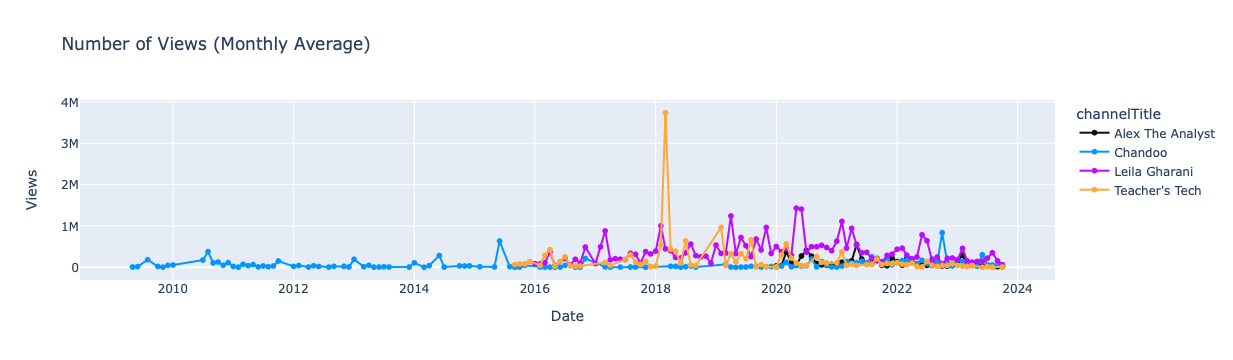

In [11]:
fig = px.line(average_views_per_month, x='year_month', y='viewCount', color='channelTitle', \
              markers=True, title='Number of Views (Monthly Average)', color_discrete_map=color_dic)
fig.update_layout(xaxis_title='Date', yaxis_title='Views')
fig.show()

**Alex's Resilient Competitiveness:**

Alex emerges as a robust contender, maintaining a close rivalry with Teachers's Tech over an extended period. This consistent competitiveness underscores Alex's enduring impact in the online education landscape.

**Chandoo's Evolutionary Journey:**

Chandoo, a trailblazer since 2009, experienced a commendable range of monthly views from 15K to 835K. However, the challenge of sustaining consistent growth in viewership since 2015 suggests a nuanced evolution. Delving into the reasons behind this pattern could unveil insights into audience dynamics and preferences.

**Teacher's Tech Peaks and Adjustments:**

Teacher's Tech achieved a zenith in March 2018 with an impressive 3.7 million monthly views, indicating a significant peak in audience engagement. However, the subsequent decline suggests a shift in dynamics, prompting a closer examination of audience preferences or alterations in content strategy during this period.

**Leila Gharani's Ascendancy:**

In a positive light, Leila Gharani stands out as a consistently high-performing figure, surpassing her competitors since 2019. The substantial increase in monthly views, from 88K to an impressive 1.4 million, signals a successful and impactful approach. An in-depth exploration of her strategies could offer valuable insights for others in the online education sphere.

**Summarily,** the online education landscape presents a dynamic canvas, with each creator following distinct trajectories. To gain a comprehensive understanding of their success or challenges, a thorough analysis of content evolution and strategic approaches is essential. This nuanced exploration will undoubtedly contribute to informed decision-making in the ever-evolving field of online education.


### Comments Per View Ratio VS Likes Per View Ratio

In [12]:
data_f['comments_to_views'] = data_f['commentCount']/data['viewCount']
data_f['likes_to_views'] = data_f['likeCount']/data_f['viewCount']


# Group by year and month and compute the average comments & likes per view ratio
average_engagement_per_month = data_f.groupby(['channelTitle', 'year_month'])['comments_to_views', 'likes_to_views'].mean().reset_index()
average_engagement_per_month.head(5)

channelTitle year_month  comments_to_views  likes_to_views
0  Alex The Analyst 2020-01-01           0.002649        0.034503
1  Alex The Analyst 2020-02-01           0.003355        0.030818
2  Alex The Analyst 2020-03-01           0.001088        0.019403
3  Alex The Analyst 2020-04-01           0.001693        0.028586
4  Alex The Analyst 2020-05-01           0.001862        0.026068

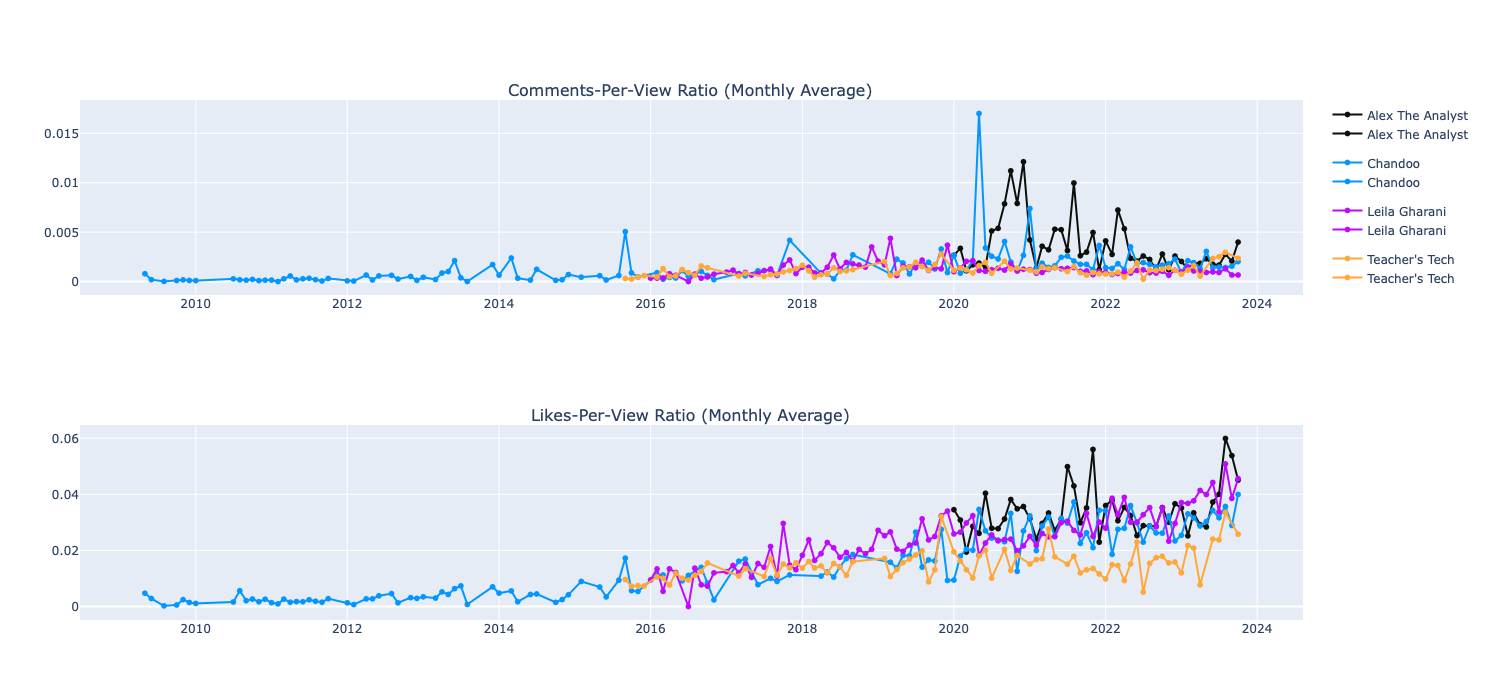

In [13]:
fig1 = px.line(average_engagement_per_month, x='year_month', y='comments_to_views',\
               color='channelTitle', markers=True, title='Comments-Per-View Ratio (Monthly Average)', color_discrete_map=color_dic)

fig2 = px.line(average_engagement_per_month, x='year_month', y='likes_to_views', \
               color='channelTitle', markers=True, title='Likes-Per-View Ratio (Monthly Average)', color_discrete_map=color_dic)


print_charts([fig1, fig2], 700)

**Alex's Engagement Dominance:**

Alex stands out with the highest overall engagement, measured by the ratio of comments and likes per view. This signifies a strong connection with the audience. However, it's noteworthy that his comment-per-view ratio experienced a decline starting from April 2022, warranting a closer examination of content strategies during this period.

**Chandoo's Peaks and Upward Trend:**

Chandoo reached an all-time high in comment-per-view among his competitors in May 2020, indicating a particularly engaging period. Additionally, he has consistently enjoyed an upward trajectory in likes-per-view, suggesting a sustained positive trend in audience appreciation.

**Leila's Like-Centric Engagement:**

Leila's content resonates strongly with viewers, reflected in a significant number of likes. However, there is a notable disparity as fewer viewers actively engage in the comment section. This dynamic prompts exploration into the factors influencing varying forms of engagement.

**Teacher's Tech's Evolving Interaction:**

While Teacher's Tech has historically maintained a lower comments-per-view, indicating a lower interaction rate, there's a promising development in the likes-per-view metric. This suggests a potential shift in the audience's interaction pattern, warranting attention and further investigation.

**In summary,** these insights unveil nuanced patterns in engagement across the analyzed creators, offering valuable points for consideration in refining content strategies and enhancing audience interaction.



### B. Analysis of Video Counts and Duration:

Here, we will dig into how often each creators publish their contents on a monthly basis and what is the length of each content. We will be using the monthly average for this.

In [14]:
average_videos_month = data_f.groupby(['channelTitle', 'year_month'])['title'].count().reset_index().rename(columns = {'title': 'n_videos'})
average_duration_month = data_f.groupby(['channelTitle', 'year_month'])['duration'].mean().reset_index()
average_videos_month.head(3)


channelTitle year_month  n_videos
0  Alex The Analyst 2020-01-01         5
1  Alex The Analyst 2020-02-01         6
2  Alex The Analyst 2020-03-01         7

In [15]:

average_duration_month.head(3)

channelTitle year_month  duration
0  Alex The Analyst 2020-01-01  5.370000
1  Alex The Analyst 2020-02-01  8.436111
2  Alex The Analyst 2020-03-01  8.228571

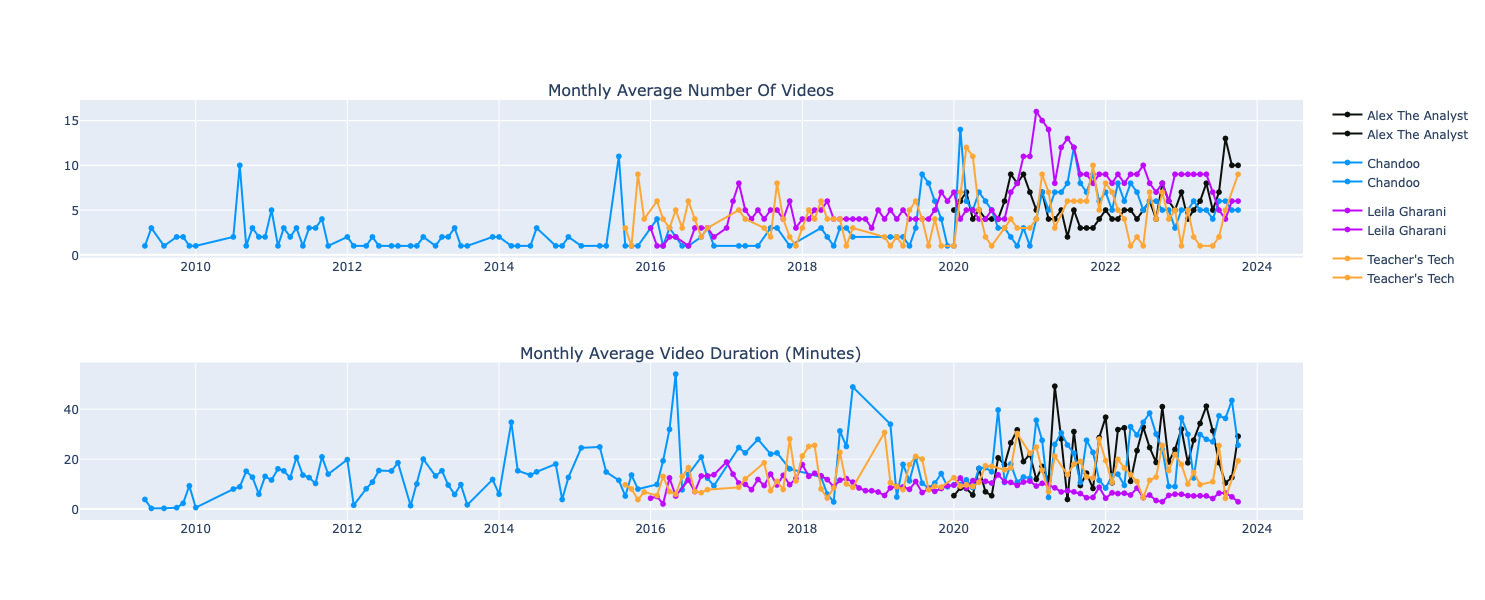

In [16]:
fig1 = px.line(average_videos_month, x='year_month', y='n_videos',\
               color='channelTitle', markers=True, title='Monthly Average Number Of Videos', color_discrete_map=color_dic)
fig2 = px.line(average_duration_month, x='year_month', y='duration', \
               color='channelTitle', markers=True, title='Monthly Average Video Duration (Minutes)', color_discrete_map=color_dic)


print_charts([fig1, fig2], 600)

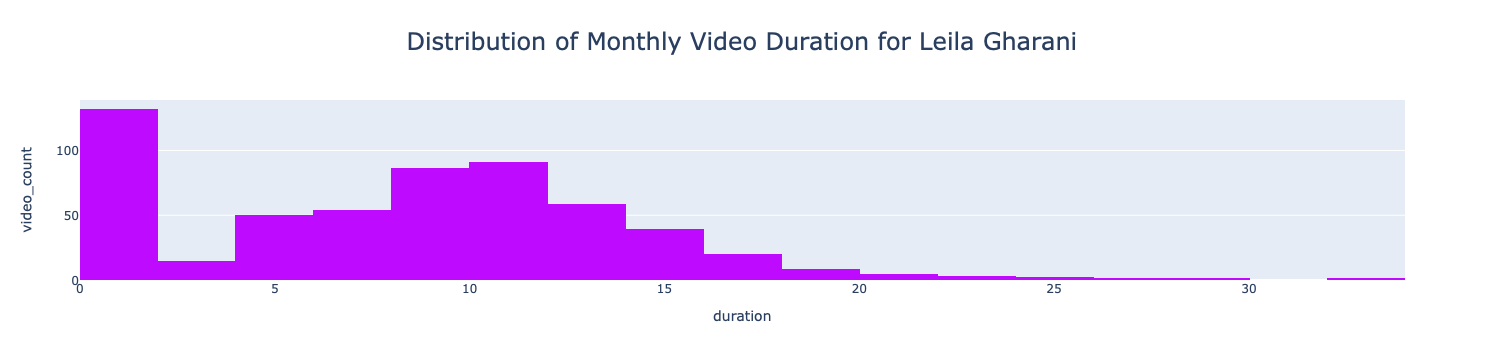

In [17]:
fig1 = px.histogram(data_f[(data_f['channelTitle'] == channel_names[0])], \
                   color_discrete_sequence = ['#be0aff'], x='duration', title=f"Distribution of Monthly Video Duration for {channel_names[0]}", nbins=25)
fig1.update_layout(yaxis_title_text = 'video_count',
    title=dict(
        text=f"Distribution of Monthly Video Duration for {channel_names[0]}",
        font=dict(size=24),
        x=0.5,
        xref="paper"
    )
)


fig1.show()

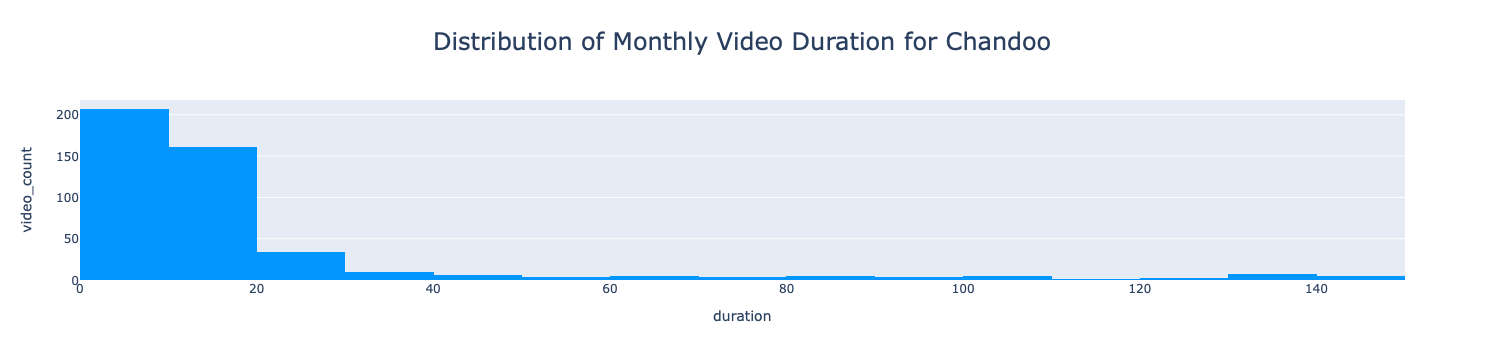

In [18]:
fig2 = px.histogram(data_f[(data_f['channelTitle'] == channel_names[1])], \
                  color_discrete_sequence = ['#0496ff'], x='duration', title=f"Distribution of Monthly Video Duration for {channel_names[1]}", nbins=25)
fig2.update_layout(yaxis_title_text = 'video_count',
    title=dict(
        text=f"Distribution of Monthly Video Duration for {channel_names[1]}",
        font=dict(size=24),
        x=0.5,
        xref="paper"
    )
)


fig2.show()

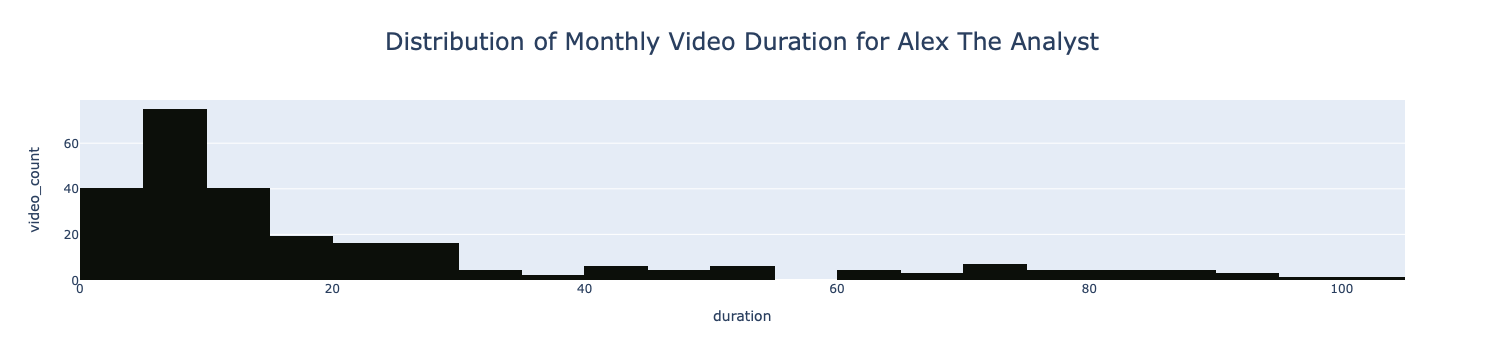

In [19]:
fig3 = px.histogram(data_f[(data_f['channelTitle'] == channel_names[2])], \
                   color_discrete_sequence = ['#0c0f0a'], x='duration', title=f"Distribution of Monthly Video Duration for {channel_names[2]}", nbins=25)
fig3.update_layout(yaxis_title_text = 'video_count',
    title=dict(
        text=f"Distribution of Monthly Video Duration for {channel_names[2]}",
        font=dict(size=24),
        x=0.5,
        xref="paper"
    )
)


fig3.show()

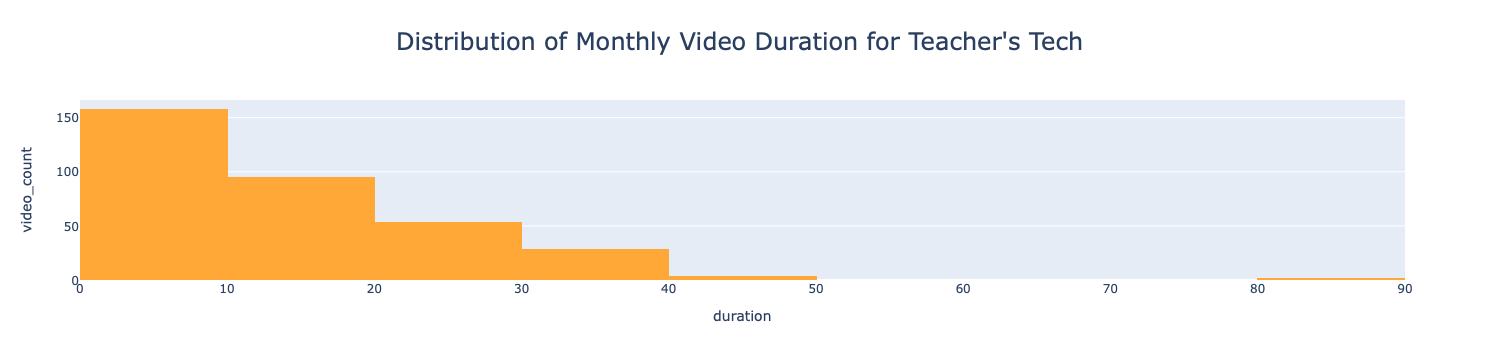

In [20]:
fig4 = px.histogram(data_f[(data_f['channelTitle'] == channel_names[3])], \
                   color_discrete_sequence = ['#ffa737'], x='duration', title=f"Distribution of Monthly Video Duration for {channel_names[3]}", nbins=15)
fig4.update_layout(yaxis_title_text = 'video_count',
    title=dict(
        text=f"Distribution of Monthly Video Duration for {channel_names[3]}",
        font=dict(size=24),
        x=0.5,
        xref="paper"
    )
)


fig4.show()

**Leila Gharani: Strategic Consistency in Video Production:**

Leila Gharani exhibits a dynamic and consistent video production schedule, ranging from 1 to 16 videos per month. Her deliberate focus on concise content, with an impressive 98% of videos lasting under 20 minutes, aligns seamlessly with the preferences of viewers seeking quick yet insightful information. This strategic brevity not only respects the audience's time but also ensures that each video delivers impactful insights efficiently.

**Alex Freberg - A Balance of Depth and Accessibility:**

Widely recognized as Alex the Analyst, Alex Freberg maintains an engaging content delivery with a monthly output ranging from 2 to 13 videos. Notably, one-third of his videos extend beyond the 20-minute mark, offering in-depth explorations. Remarkably, 67% of his content remains within the viewer-friendly timeframe of under 20 minutes, striking a commendable balance between providing detailed insights and ensuring accessibility for a diverse audience.

**Teacher's Tech - Skillful Balance in Duration:**

Teacher's Tech adopts a posting frequency ranging from 1 to 12 videos per month, featuring an average video duration of up to 30 minutes. However, a skillful 74% of his videos are crafted to captivate audiences in under 20 minutes, showcasing a thoughtful equilibrium between depth and accessibility. This approach ensures that the majority of his content remains engaging and digestible for a broad audience.

**Chandoo - Commitment to Conciseness:**

Chandoo consistently delivers up to 14 videos per month, marked by a notable 81% of videos lasting less than 20 minutes. This intentional choice reflects his commitment to providing concise and focused insights, aligning closely with the preferences of his audience. Chandoo's dedication to brevity ensures that his content remains easily consumable while delivering valuable information.

**In Summary - Diverse Approaches, Shared Emphasis on Accessibility:**
In summary, each content creator employs a unique approach to both frequency and duration, tailored to their individual styles. Despite these differences, there is a shared emphasis on creating digestible content, making it accessible and appealing to their diverse audience base. This strategic alignment with audience preferences underscores the creators' understanding of the importance of delivering content that is both engaging and respectful of viewers' time.

### C. Publishing Schedule:

Here,  I will be focusing on publishing schedule from 2021 to 2023. This involves a meticulous analysis of their publishing strategies, including frequency, timing, and consistency.

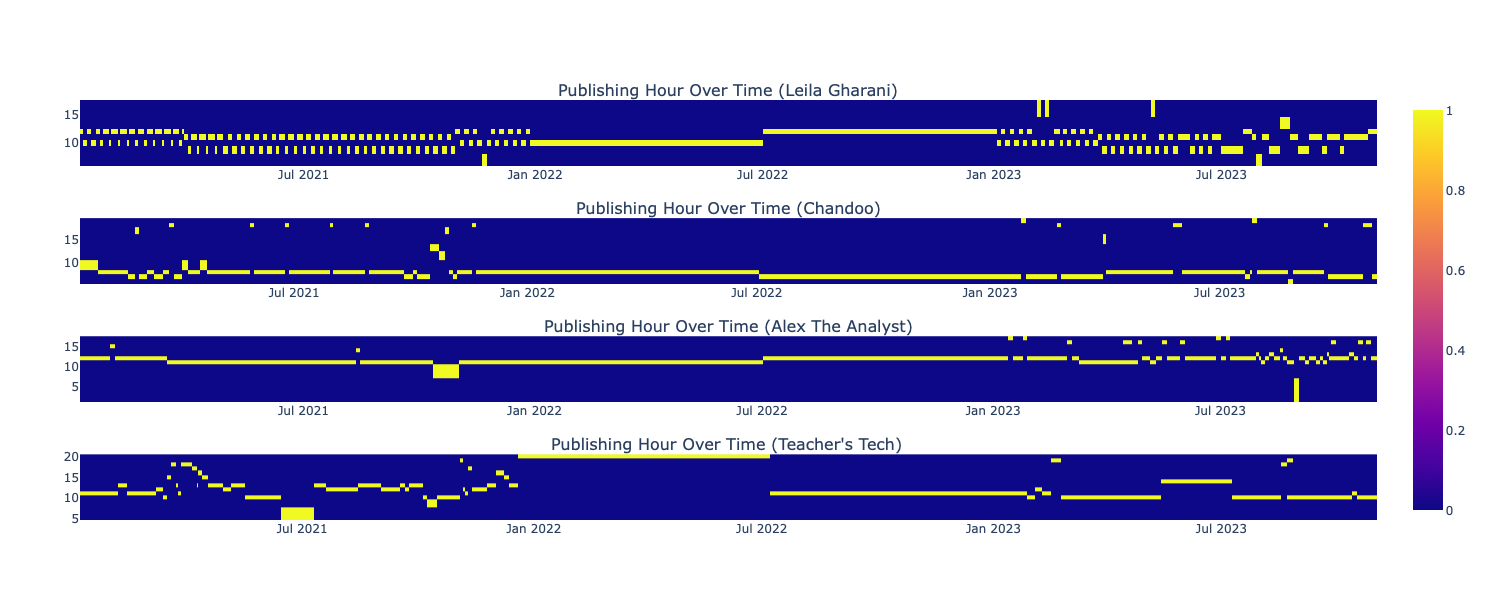

In [21]:
# Seperating the Hour
data_f['date'] = data_f['publishedAt'].dt.date
data_f['hour'] = data_f['publishedAt'].dt.hour

def create_heatmap(years, channel_name):
    
    pivot = data_f[(data_f['year'].isin(years)) & (data_f['channelTitle'] == channel_name )]. \
    pivot_table(index='hour', columns='date', aggfunc='size', fill_value=0)
    
    fig = px.imshow(pivot, labels=dict(x="Date", y="Hour", color="Frequency"), 
                title = f"Publishing Hour Over Time ({channel_name})")
    
    return fig

print_charts( [create_heatmap([2021, 2023], name) for name in data_f['channelTitle'].unique()], 600)

**Leila Gharani's Strategic Posting for Consistent Viewership:**

Over time, Leila Gharani has demonstrated a keen understanding of her audience's habits, strategically posting content within the early hours of the day, specifically targeting the window between 8 am and 12 noon. This thoughtful scheduling has proven instrumental in consistently gaining more viewerships. By aligning her content with the diverse preferences of viewers throughout this timeframe, she has successfully captured the attention of a varied audience, contributing to the steady growth in her viewership.

**Chandoo's Early Morning Consistency:**

Chandoo adopts a focused approach by predominantly posting his content between 7 am and 8 am in the morning. This early morning consistency suggests a deliberate effort to reach his audience during a specific and potentially high-engagement period. Chandoo's commitment to this posting window reflects a strategic choice that may be optimized for audience availability and interaction during these early hours.

**Alex's Regularized Midday Presence:**

Alex, known as Alex the Analyst, has established a regular posting routine, typically sharing content between 11 am and 12 noon. This midday consistency suggests a deliberate effort to capture the attention of his audience during a period that may align with peak viewership or engagement. By adhering to this regularized schedule, Alex has created an expectation among his audience, fostering anticipation for his content during these hours.

**Teacher's Tech: Varied Posting Patterns:**

In contrast to the structured posting schedules of Leila Gharani, Chandoo, and Alex, Teacher's Tech does not adhere to a specific pattern in his content postings. This divergence in approach may reflect a unique strategy tailored to the unpredictable nature of his audience or content type. While not following a set schedule, Teacher's Tech might be leveraging flexibility to cater to different viewer demographics or preferences.

**In summary,** the analysis of posting patterns reveals distinct strategies among these content creators, showcasing their adaptability and strategic thinking in reaching and engaging their respective audiences.

### D. Tags and Titles:

Here we will be detecting the most used tags and titles of the most watched videos by these content creators.

#### Most Used Tags

In [22]:
def top_tags_by_year(data_f, channel_title, n_tags):
    '''
    get top 7 tags used in videos in a corresponding
    '''
    # Flatten the list of tags by year and count occurrences
    selected = data_f[data_f['channelTitle'] == channel_title]
    all_tags = selected.explode('tags').groupby(['year', 'tags']).size().reset_index(name='count')

    # Sort and filter out the top 5 tags for each year
    top_tags = all_tags.groupby('year').apply(lambda x: x.nlargest(n_tags, 'count')).reset_index(drop=True)

    # Create a pivot table with years as columns and top tags as rows
    pivot_table = top_tags.pivot_table(index=top_tags.groupby('year').cumcount(), columns='year', values='tags', aggfunc='first')

    print(f"Top 5 Tags By Year for {channel_title}")
    return pivot_table


In [23]:

for n in range(len(channel_names)):
    display(top_tags_by_year(data_f, channel_names[n], n_tags = 7))

Top 5 Tags By Year for Leila Gharani


year                         2016                      2017  \
0                   Leila Gharani             Leila Gharani   
1                      XelplusVis                XelplusVis   
2                      Excel Tips  Advanced Excel Tutorials   
3           Advanced Excel charts                Excel 2016   
4           Excel Tips and Tricks                Excel 2013   
5                    excel graphs        Excel for analysts   
6     Data Visualization in Excel                Excel 2010   

year                   2018                   2019                       2020  \
0             Leila Gharani          Leila Gharani              Leila Gharani   
1                XelplusVis             XelplusVis                 XelplusVis   
2                Excel 2013    Excel online course                    XelPlus   
3                Excel 2016  Excel tips and tricks        Excel online course   
4                Excel 2010     Excel for analysts            Microsoft Excel   
5       Excel online course  Advanced Excel tricks  Microsoft Excel tutorials   
6     Excel tips and tricks             Excel 2016      Excel tips and tricks   

year                       2021                   2022                   2023  
0                 Leila Gharani          Leila Gharani          Leila Gharani  
1                    XelplusVis             XelplusVis             XelplusVis  
2                       XelPlus                XelPlus                XelPlus  
3                 Microsoft 365          Microsoft 365          Microsoft 365  
4     Microsoft Excel tutorials  Advanced Excel tricks  Advanced Excel tricks  
5            Excel for analysts    Excel online course              Excel 365  
6         Excel tips and tricks        Microsoft Excel     Excel for analysts

Top 5 Tags By Year for Chandoo


year           2009           2010          2011                        2012  \
0             excel          excel         excel                 chandoo.org   
1      spreadsheets       tutorial     education                       excel   
2          charting         charts  spreadsheets  Microsoft Excel (Software)   
3         tutorials       formulas   chandoo.org                      macros   
4     visualization          howto     tutorials                         vba   
5         15sectuts       software           vba                    charting   
6         Microsoft  tips & tricks        macros                      Office   

year                        2013                        2014  \
0                          excel                 chandoo.org   
1                    chandoo.org             excel tutorials   
2                      tutorials  Microsoft Excel (Software)   
3     Microsoft Excel (Software)                       excel   
4                      education       excel tutorials video   
5                excel tutorials                       india   
6          excel tutorials video                spreadsheets   

year                        2015          2016         2017          2018  \
0                    chandoo.org   chandoo.org  chandoo.org       chandoo   
1     Microsoft Excel (Software)         excel    tutorials   chandoo.org   
2                      tutorials     tutorials        excel  spreadsheets   
3                          excel  spreadsheets     power bi         excel   
4                       tutorial      charting  power query         Excel   
5                   spreadsheets     analytics        Excel     tutorials   
6                          Chart       slicers   dashboards      charting   

year          2019                                   2020  \
0          chandoo                                chandoo   
1      chandoo.org                            chandoo.org   
2            Excel                                  Excel   
3     spreadsheets                           spreadsheets   
4         power bi                            power query   
5          powerbi              9 box grid excel template   
6          vlookup  9 box grid for performance management   

year                   2021               2022               2023  
0                   chandoo            chandoo            chandoo  
1               chandoo.org        chandoo.org        chandoo.org  
2                     Excel              Excel              Excel  
3              spreadsheets       spreadsheets       spreadsheets  
4                  power bi           power bi           power bi  
5           microsoft excel  power bi tutorial    microsoft excel  
6     advanced excel tricks    excel dashboard  power bi tutorial

Top 5 Tags By Year for Alex The Analyst


year                             2020                 2021  \
0                        Data Analyst     Alex The Analyst   
1        How to become a data analyst         Data Analyst   
2                      Data Analytics       Data Analytics   
3                    Data Analyst job  Data Analyst Career   
4                 Data Analyst Career     Data Analyst job   
5     Data Analyst with no experience        tableau basic   
6         Data analyst with no degree       tableau basics   

year                 2022                 2023  
0        Alex The Analyst     Alex The Analyst  
1     Data Analyst Career         Data Analyst  
2          Data Analytics  Data Analyst Career  
3        Data Analyst job     Data Analyst job  
4            Data Analyst       Data Analytics  
5                power bi           livestream  
6       power bi tutorial               pandas

Top 5 Tags By Year for Teacher's Tech


year                     2015             2016             2017  \
0           Teacher Tech Tips    teachers tech    teachers tech   
1                       jkeet  google calendar     google forms   
2                Google Drive     google forms  google calendar   
3                       JKeet   microsoft sway     google drive   
4      Educational Technology     google sites     teacher tech   
5                 Google Docs            jkeet      google docs   
6     Google Search (Website)         tutorial   google hangout   

year               2018                         2019                    2020  \
0         teachers tech               teacher's tech          teacher's tech   
1     free video editor                teachers tech           teachers tech   
2        microsoft word       best free video editor             google meet   
3          google drive             filmora tutorial  how to use google meet   
4            gmail 2018          wondershare filmora     how to teach online   
5        gmail tutorial  best video editing software         online learning   
6         google slides                    filmora 9         remote learning   

year                      2021                      2022  \
0                   jamie keet                jamie keet   
1                teachers tech             teachers tech   
2              microsoft excel                     excel   
3               excel tutorial           microsoft excel   
4     teacher's tech tutorials  teacher's tech tutorials   
5                        excel            excel tutorial   
6               teacher's tech            teacher's tech   

year                   2023  
0                jamie keet  
1             teachers tech  
2            teacher's tech  
3     excel tips and tricks  
4      adobe acrobat pro dc  
5                     figma  
6                 ux design

#### Titles of the most viewed contents

In [24]:
# Sort and get top 10 (or less if less than 10 videos) videos for each channel
top_videos = data_f[['channelTitle', 'title', 'viewCount']].sort_values(['channelTitle', 'viewCount'], ascending=[True, False]) \
               .groupby('channelTitle').head(10)
top_videos

channelTitle  \
qfyynHBFOsM  Alex The Analyst   
RSlqWnP-Dy8  Alex The Analyst   
M2ySRYpo9S0  Alex The Analyst   
ywZXpfdqg1o  Alex The Analyst   
CUBfrdDwznQ  Alex The Analyst   
fUpChfNN5Uo  Alex The Analyst   
G4syHs3M82E  Alex The Analyst   
rGx1QNdYzvs  Alex The Analyst   
-bSkREem8dM  Alex The Analyst   
opJgMj1IUrc  Alex The Analyst   
L3-uVawPLKc           Chandoo   
HgfC3etOgsU           Chandoo   
v2oNWja7M2E           Chandoo   
B1WWWGeFqTM           Chandoo   
k_ugshJ4wIw           Chandoo   
SPFQX82X03Q           Chandoo   
l8DCPaHc5TQ           Chandoo   
FHEPx4KjlG8           Chandoo   
pIbL4aSUIas           Chandoo   
o_3m90XPDJI           Chandoo   
L4j4oGbfRy4     Leila Gharani   
nzH4KPz_cIs     Leila Gharani   
JZewxiKFplk     Leila Gharani   
a83EmWtZMfg     Leila Gharani   
Poepoh1b_3k     Leila Gharani   
F264FpBDX28     Leila Gharani   
KkTaQ5OjAGc     Leila Gharani   
UsdedFoTA68     Leila Gharani   
4c0CLUER6nw     Leila Gharani   
5M2Kq_5V24A     Leila Gharani   
k1VUZEVuDJ8    Teacher's Tech   
wGXI0KpkR50    Teacher's Tech   
pl-tBjAM9g4    Teacher's Tech   
HC13M8FGlNc    Teacher's Tech   
bhZckWTLkJM    Teacher's Tech   
sURH2CxmaXQ    Teacher's Tech   
JQD5c8A_D2g    Teacher's Tech   
Lw03WcG4mt4    Teacher's Tech   
hlDG90sbhQY    Teacher's Tech   
DPZb3D0500I    Teacher's Tech   

                                                         title  viewCount  
qfyynHBFOsM  Data Analyst Portfolio Project | SQL Data Expl...    1548839  
RSlqWnP-Dy8  SQL Basics Tutorial For Beginners | Installing...    1060584  
M2ySRYpo9S0         Top 5 Reasons Not to Become a Data Analyst     913798  
ywZXpfdqg1o              What Does a Data Analyst Actually Do?     843048  
CUBfrdDwznQ  How to Become a Data Analyst in 2023 (Complete...     803351  
fUpChfNN5Uo  Data Scientist vs Data Analyst | Which Is Righ...     752111  
G4syHs3M82E  Data Analyst vs Business Analyst | Which Is Ri...     729594  
rGx1QNdYzvs                       FREE Data Analyst Bootcamp!!     658450  
-bSkREem8dM  Database vs Data Warehouse vs Data Lake | What...     539458  
opJgMj1IUrc  Full Project in Excel | Excel Tutorials for Be...     508974  
L3-uVawPLKc                   What is Excel and How to use it?    2594078  
HgfC3etOgsU         I saw my boss do these 10 things in Excel!    2565846  
v2oNWja7M2E    Beginner to Pro FREE Excel Data Analysis Course    1682309  
B1WWWGeFqTM  Top 5 Excel Functions for Finance People (with...    1472463  
k_ugshJ4wIw  AWESOME Excel trick to combine data from multi...     930981  
SPFQX82X03Q  I don't use PIVOT tables anymore... I use this...     906534  
l8DCPaHc5TQ  Learn SQL for Data Analysis in one hour (with ...     792528  
FHEPx4KjlG8  How I made $100K as Excel Freelancer - 4 life ...     684671  
pIbL4aSUIas  BUSINESS Analyst vs. DATA Analyst - What do th...     683885  
o_3m90XPDJI  Calculating total working hours using Excel - ...     635517  
L4j4oGbfRy4  What Your Boss Can TRACK About YOU with Micros...    6436016  
nzH4KPz_cIs  3 Cool Effects You Did NOT Think are Possible ...    6285299  
JZewxiKFplk  How to Create a Dynamic Numbered List in Excel...    5688184  
a83EmWtZMfg       Do NOT Shut Down Your Computer! (here's why)    4536398  
Poepoh1b_3k  How to Use OneNote Effectively (Stay organized...    4118385  
F264FpBDX28       How to use Excel Index Match (the right way)    3425330  
KkTaQ5OjAGc  Excel IF Formula: Simple to Advanced (multiple...    3361403  
UsdedFoTA68  Excel Pivot Tables EXPLAINED in 10 Minutes (Pr...    3295490  
4c0CLUER6nw  How to Use the NEW & IMPROVED Excel XLOOKUP (w...    3252139  
5M2Kq_5V24A  TOO MANY EMAILS? Use THESE Proven Techniques |...    2883773  
k1VUZEVuDJ8      Microsoft Excel Tutorial -  Beginners Level 1   11944167  
wGXI0KpkR50         How to Use Google Meet - Detailed Tutorial    2727141  
pl-tBjAM9g4  How to Use Google Classroom - Tutorial for Beg...    2337757  
HC13M8FGlNc        Microsoft Word Tutorial - Beginners Level 1    2307074  
bhZ

In [25]:
# Pivot the table to get desired structure
pivot_df = top_videos.set_index(['channelTitle', top_videos.groupby('channelTitle').cumcount()]).unstack(0)

# Display the result
pivot_df

title  \
channelTitle                                   Alex The Analyst   
0             Data Analyst Portfolio Project | SQL Data Expl...   
1             SQL Basics Tutorial For Beginners | Installing...   
2                    Top 5 Reasons Not to Become a Data Analyst   
3                         What Does a Data Analyst Actually Do?   
4             How to Become a Data Analyst in 2023 (Complete...   
5             Data Scientist vs Data Analyst | Which Is Righ...   
6             Data Analyst vs Business Analyst | Which Is Ri...   
7                                  FREE Data Analyst Bootcamp!!   
8             Database vs Data Warehouse vs Data Lake | What...   
9             Full Project in Excel | Excel Tutorials for Be...   

                                                                 \
channelTitle                                            Chandoo   
0                              What is Excel and How to use it?   
1                    I saw my boss do these 10 things in Excel!   
2               Beginner to Pro FREE Excel Data Analysis Course   
3             Top 5 Excel Functions for Finance People (with...   
4             AWESOME Excel trick to combine data from multi...   
5             I don't use PIVOT tables anymore... I use this...   
6             Learn SQL for Data Analysis in one hour (with ...   
7             How I made $100K as Excel Freelancer - 4 life ...   
8             BUSINESS Analyst vs. DATA Analyst - What do th...   
9             Calculating total working hours using Excel - ...   

                                                                 \
channelTitle                                      Leila Gharani   
0             What Your Boss Can TRACK About YOU with Micros...   
1             3 Cool Effects You Did NOT Think are Possible ...   
2             How to Create a Dynamic Numbered List in Excel...   
3                  Do NOT Shut Down Your Computer! (here's why)   
4             How to Use OneNote Effectively (Stay organized...   
5                  How to use Excel Index Match (the right way)   
6             Excel IF Formula: Simple to Advanced (multiple...   
7             Excel Pivot Tables EXPLAINED in 10 Minutes (Pr...   
8             How to Use the NEW & IMPROVED Excel XLOOKUP (w...   
9             TOO MANY EMAILS? Use THESE Proven Techniques |...   

                                                                 \
channelTitle                                     Teacher's Tech   
0                 Microsoft Excel Tutorial -  Beginners Level 1   
1                    How to Use Google Meet - Detailed Tutorial   
2             How to Use Google Classroom - Tutorial for Beg...   
3                   Microsoft Word Tutorial - Beginners Level 1   
4                  Microsoft Excel Tutorial - Beginners Level 2   
5                   Filmora9  Tutorial - Designed for Beginners   
6                             7 Tips to Get More Out of OneNote   
7                       Vlookup Function in Excel for Beginners   
8             Shotcut Video Editor Tutorial - Designed for B...   
9                How to Use Google Hangouts - Detailed Tutorial   

                    viewCount                                        
channelTitle Alex The Analyst  Chandoo Leila Gharani Teacher's Tech  
0                     1548839  2594078       6436016       11944167  
1                     1060584  2565846       6285299        2727141  
2                      913798  1682309       5688184        2337757  
3                      843048  1472463       4536398        2307074  
4                      803351   930981       4118385        2233308  
5                      752111   906534       3425330        1763622  
6                      729594   792528       3361403        1448107  
7                      658450   684671       3295490        1399665  
8                      539458   683885       3252139        1219002  
9                      508974   635517       2883773        1204951

**Alex's Pinnacle in Data Analytics Education:**

Alex has achieved significant success with his most viewed content, centering on data analytics and SQL tutorials. Notably, the content takes a deep dive into a portfolio project, showcasing Alex's proficiency in imparting complex concepts in a digestible manner. This valuable resource resonates with audiences seeking practical insights into the application of data analytics methodologies.

**Chandoo's Excel Excellence:**
Chandoo's most popular content revolves around Excel tutorials, serving as a cornerstone for individuals seeking comprehensive guidance in understanding and effectively utilizing Microsoft Excel. Chandoo's expertise shines through in these tutorials, providing a valuable educational asset for users aiming to enhance their proficiency in spreadsheet software.

**Leila Gharani's Tech-Pertise in Privacy Matters:**
Leila Gharani has garnered substantial viewership with content focused on workplace technology and privacy concerns. Her exploration of what employers can track using Microsoft tools adds a critical layer of insight to the discourse on technology's impact on privacy in professional settings. Leila's content not only informs but sparks necessary conversations around the evolving landscape of workplace technology.

**Teacher's Tech's Gateway to Excel Proficiency:**
Teacher's Tech has achieved notable success with beginner-level tutorials for Microsoft Excel, attracting viewers who are new to using the software. These tutorials serve as a welcoming entry point for individuals navigating the complexities of Excel, reflecting Teacher's Tech commitment to educational inclusivity and ensuring that foundational skills are accessible to all.

**In summary,** each content creator has carved out a distinct niche in their most viewed content, showcasing expertise, relevance, and an understanding of their audience's educational needs. These insights not only highlight their individual successes but also contribute to the broader landscape of educational content on data analytics, Excel, workplace technology, and privacy concerns.

#### Words ranked by views

Here we will identify the buzz words creators can always use to gain more viewerships

In [26]:
def rank_words_by_views(titles, view_counts, stop_words=[]):
    '''
    The function dissects video titles into individual words, eliminating punctuation and specified stop words, while also extracting word stems. 
    It outputs a list of these word stems alongside the corresponding number of views for videos with titles incorporating each word.
    
    titles: An array containing video titles.
    view_counts: An array containing the respective number of views for each video.
    stop_words: A list of words designated for exclusion from the analysis.
    '''
    
    ps = PorterStemmer()
    translator = str.maketrans('', '', string.punctuation)
    words = [ps.stem(word) for title in titles for word in title.translate(translator).lower().split() \
                                                                            if word not in stop_words]
    word_views = Counter({word: 0 for word in words})
    
    for title, count in zip(titles, view_counts):
        for word in set(title.translate(translator).lower().split()):
            stemmed_word = ps.stem(word)
            if stemmed_word in word_views:
                word_views[stemmed_word] += count
                
    infrequent_words = [word for word, count in Counter(words).items() if count < 5]
    for word in infrequent_words:
        del word_views[word]

    sorted_words, sorted_word_counts = zip(*word_views.most_common())
    return list(sorted_words), np.array(sorted_word_counts)


# Generate word cloud
def generate_word_cloud(words, counts):
    '''
    the function generates a diagram with word cloud.
    
    words - array of words
    counts - array of numerical values (views in our case)
    
    '''
    word_freq = {word: count for word, count in zip(words, counts)}
    wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(word_freq)
    
    # Display using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

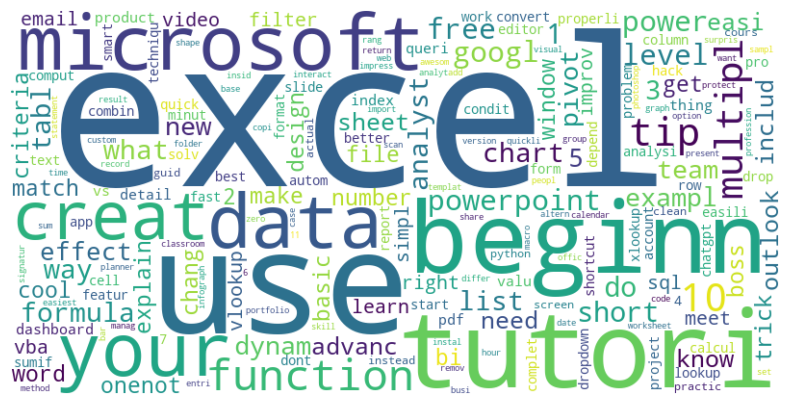

In [27]:
top_words, top_counts = rank_words_by_views(data_f['title'].values, data_f['viewCount'].values, stop_words=ENGLISH_STOP_WORDS)
generate_word_cloud(top_words, top_counts)

####  Title/Descriptions Length And Number Of Tags

Here will dive into some of the factors YouTube takes into account in its algorithm. Such factors are:
- number of tags
- description length
- title length

In [28]:
#calculating lengths of title, description and list of tags
data_f['title_length'] = data_f['title'].apply(lambda x: len(x)) 
data_f['description_length'] = data_f['description'].apply(lambda x: len(x))
data_f['tags_length'] = data_f['tags'].apply(lambda x: len(x))

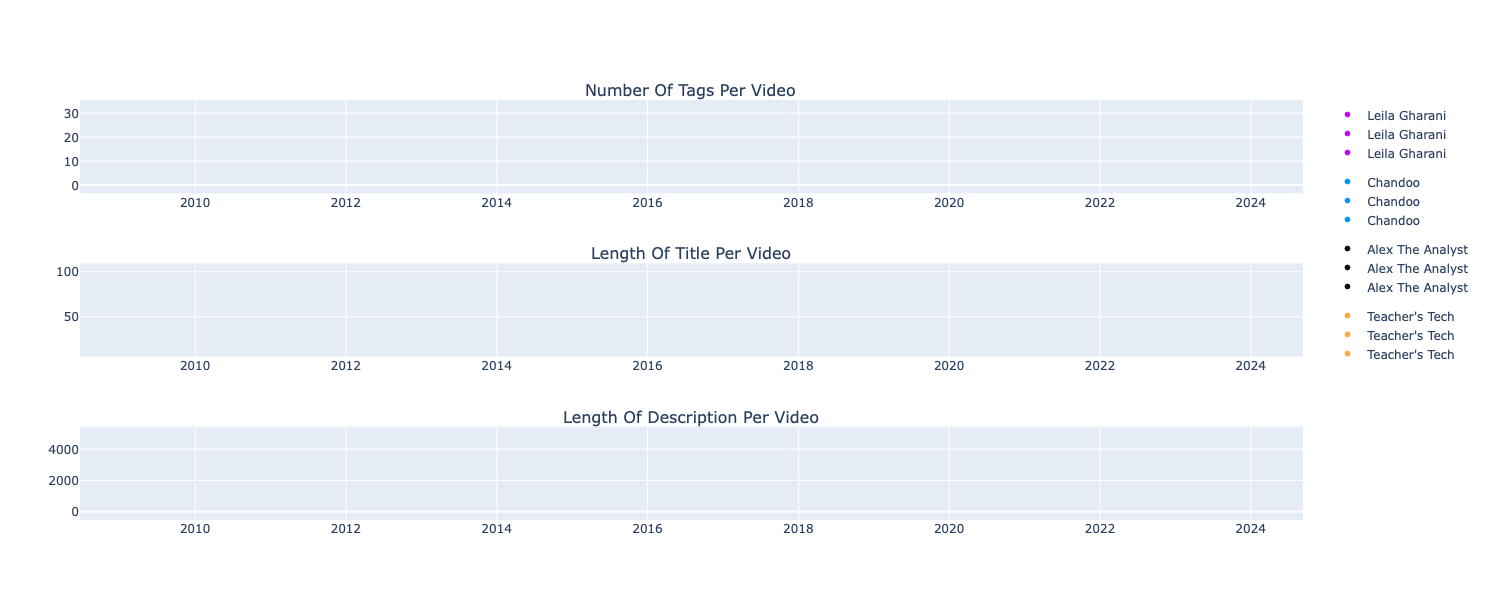

In [29]:
fig_tags = px.scatter(data_f, x='date', y='tags_length',\
                      color='channelTitle', title='Number Of Tags Per Video',  color_discrete_map=color_dic)
fig_title = px.scatter(data_f, x='date', y='title_length',\
                      color='channelTitle', title='Length Of Title Per Video', color_discrete_map=color_dic)
fig_description = px.scatter(data_f, x='date', y='description_length',\
                      color='channelTitle', title='Length Of Description Per Video', color_discrete_map=color_dic)



print_charts( [fig_tags, fig_title, fig_description], 600)

**Strategic Use of Tags and its Influence on Viewership:**

Teacher's Tech and Leila Gharani lead the way with 32 and 31 tags, respectively. Leila Gharani consistently maintains a tag range between 22 and 31, showcasing a thoughtful and strategic approach. Conversely, Teacher's Tech shows a declining trend in tag usage, particularly noticeable in early 2021, impacting his viewership. In contrast, Chandoo's deliberate increase in tag usage from early 2021 aligns with a considerable uptick in viewership during that period. Interestingly, Alex employs the fewest tags, opting for a minimalist approach among the content creators.

**Consistent Title Length Practices:**
Content creators uniformly adhere to title lengths ranging from 15 to 100 characters. This standardized approach reflects a collective understanding of the optimal title length for engaging audiences without overwhelming them. Such consistency aligns with industry best practices, contributing to an enhanced overall viewer experience.

**Strategic Considerations in Description Length:**
Leila and Chandoo distinguish themselves by favoring lengthier descriptions. This strategic choice likely results from the inclusion of advertisements or links, adding depth and context to their content. This intentional approach to description length aligns with a sophisticated content strategy, aiming to provide comprehensive information and engage viewers beyond the video content itself.

### Recommendations:

**Teacher's Tech:** Given the declining trend in tag usage impacting viewership, consider reevaluating tag strategies and possibly exploring more tags. Additionally, refine posting patterns to align with audience preferences and maximize engagement during specific timeframes.

**Chandoo:** Capitalize on the positive trend in likes-per-view by further optimizing content to enhance engagement. Investigate factors contributing to comment-per-view peaks for insights into audience preferences. Consider maintaining the upward trajectory in tag usage.

**Alex:** Despite overall high engagement, delve into the decline in comment-per-view ratio from April 2022 to understand changing audience dynamics. Ensure content strategies align with evolving viewer preferences and explore potential adjustments.